# Emergency braking - check results 4__label_collison

<br>

<hr>

## Description

This notebook check the log results of 4__label_collison 

4__label_collison runs experiments using DreemNet on the Emergency Braking dataset and predicting events that correspond either to a collison (1), or not (0)

In [2]:
import os
import torch
import matplotlib 
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from scipy.stats import iqr

from mpl_toolkits.mplot3d import Axes3D # For 3d scatterplots

## Window size study

Ths study is done over balanced data for one subject with labels braking and no braking 

In [18]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '5__windowsize_label_braking/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [65]:
values_auc = []
values_f1score = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    path_temp2 = os.path.join(path_to_results,path_to_example, forlder_name, "f1score_test")
    
    file_names = sorted(os.listdir(path=path_temp))
    file_names = [x for x in file_names if not x.startswith('.')]
    
    file_names2 = sorted(os.listdir(path=path_temp2))
    file_names2 = [x for x in file_names2 if not x.startswith('.')]
    
    for event in summary_iterator(os.path.join(path_temp,file_names[0])):
        for value in event.summary.value:
            values_auc.append(value.simple_value)
            
    for event in summary_iterator(os.path.join(path_temp2,file_names2[0])):
        for value in event.summary.value:
            values_f1score.append(value.simple_value)

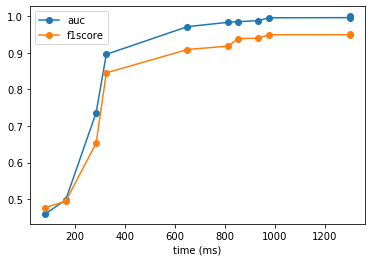

In [94]:
windo_size = np.array([320, 320, 70, 240,160, 80, 40, 20, 200, 230, 210])
convert_ms = 5*(260/320)
plt.plot(np.sort(np.array([windo_size*convert_ms,values_auc]))[0,],np.sort(np.array([windo_size*convert_ms,values_auc]))[1,],'o-', label="auc")
plt.plot(np.sort(np.array([windo_size*convert_ms,values_f1score]))[0,],np.sort(np.array([windo_size*convert_ms,values_f1score]))[1,],'o-', label="f1score")

plt.xlabel("time (ms)")
#plt.ylabel("AUC")
plt.legend()
plt.savefig("Plots/window_size_braking_driving.png")

## Learning rate and batch size study

Ths study is done over unbalanced data for all subject with labels collision and normal braking. The baseline fit is very noisy, it dosen't seem to converge, and AUC varies between 1 and 0, suggesting that the stochastic optimizer is jumping all around the space without really converging.

So we'll try to run the optimizer dereministically

In [137]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '4__label_collison/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [138]:
values_auc_train = []
values_auc_test = []
iqr_auc_train = []
batch_size = []
learning_rate = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_train")
    path_meta = os.path.join(path_to_results,path_to_example, forlder_name, "meta_tags.csv")
    path_auc_test = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    
    if(os.path.isdir(path_auc_test)):
        meta_data = pd.read_csv(path_meta)
        batch_size.append(int(meta_data.loc[meta_data['key'] == 'batch_size', 'value']))
        learning_rate.append(float(meta_data.loc[meta_data['key'] == 'lr', 'value']))

        file_names = sorted(os.listdir(path=path_temp))
        file_names = [x for x in file_names if not x.startswith('.')]

        # file_names2 = sorted(os.listdir(path=path_temp2))
        # file_names2 = [x for x in file_names2 if not x.startswith('.')]
        value_temp =[]
        for event in summary_iterator(os.path.join(path_temp,file_names[0])):
            for value in event.summary.value:
                value_temp.append(value.simple_value)
        value_temp = np.array(value_temp)
        value_temp = value_temp[~np.isnan(value_temp)]
        values_auc_train.append(value_temp)
        iqr_auc_train.append(iqr(value_temp, rng=(0,100)))

        #
        #if(os.path.isdir(path_auc_test)):
        file_names = sorted(os.listdir(path=path_auc_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_auc_test,file_names[0])):
            for value in event.summary.value:
                values_auc_test.append(value.simple_value)
    #else:
    #    values_auc_test.append('nan')

In [139]:
df_results = pd.DataFrame({'batch':batch_size,'learning':learning_rate,
                           'learning_log':np.log(learning_rate), 
                           'iqr':iqr_auc_train, 
                            'auc_test':values_auc_test})

In [140]:
df_results = df_results.sort_values('learning')

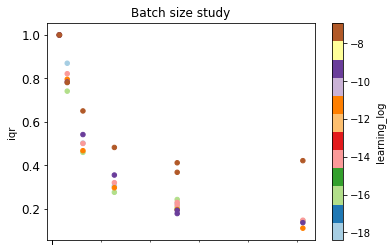

In [141]:
labels = df_results['learning'].unique()
ax = df_results.plot(x='batch',
                      y='iqr',
                      c='learning_log',
                      colormap='Paired',
                      title = 'Batch size study',
                      kind = 'scatter',
                      figsize = (6,4), 
                      xticks = labels,
                      fontsize = 12)
ax.set(xlabel="batch size", ylabel="iqr")
ax.set_xticklabels(labels)
plt.savefig("Plots/batch_collision_braking.png")

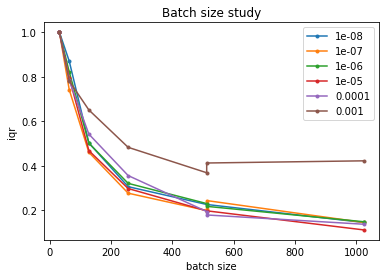

In [142]:
labels_x = df_results['learning'].unique()
df_results = df_results.sort_values('batch')
fig, ax = plt.subplots()
for key, grp in df_results.groupby(['learning']):
    ax = grp.plot(ax=ax, kind='line', x='batch', y='iqr', label=key,style='.-',title = 'Batch size study')
ax.set(xlabel="batch size", ylabel="iqr")
plt.legend(loc='best')
plt.savefig("Plots/batch_collision_braking.png")

In [144]:
df_results

,batch,learning,learning_log,iqr,auc_test
40,32,1.000000e-08,-18.420681,1.000000,0.504905
38,1024,1.000000e-08,-18.420681,0.144679,0.543365
36,128,1.000000e-08,-18.420681,0.502530,0.527624
39,64,1.000000e-08,-18.420681,0.870018,0.499261
41,512,1.000000e-08,-18.420681,0.225660,0.541392
37,256,1.000000e-08,-18.420681,0.305671,0.461915
35,32,1.000000e-08,-18.420681,1.000000,0.517185
28,32,1.000000e-07,-16.118096,1.000000,0.468055
32,256,1.000000e-07,-16.118096,0.276432,0.527723
34,1024,1.000000e-07,-16.118096,0.144732,0.501235


In [147]:
labels_x

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

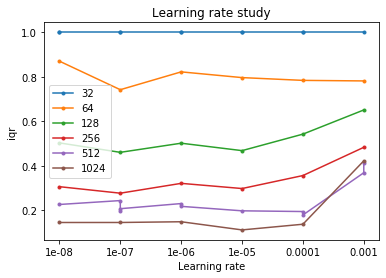

In [148]:
labels_x = df_results['learning'].unique()
df_results = df_results.sort_values('learning')
fig, ax = plt.subplots()

for key, grp in df_results.groupby(['batch']):
    ax = grp.plot(ax=ax, kind='line', x='learning_log', y='iqr', label=key,style='.-',title = 'Learning rate study')
ax.set(xlabel="Learning rate", ylabel="iqr")
ax.set_xticks(df_results['learning_log'].unique())
ax.set_xticklabels(labels_x)
plt.legend(loc='best')
plt.savefig("Plots/lr_collision_braking.png")

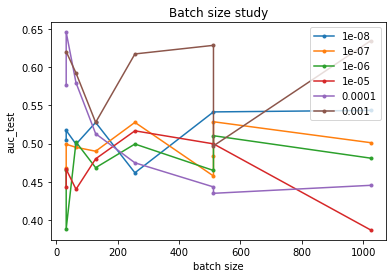

In [125]:
labels_x = df_results['learning'].unique()
df_results = df_results.sort_values('batch')
fig, ax = plt.subplots()
for key, grp in df_results.groupby(['learning']):
    ax = grp.plot(ax=ax, kind='line', x='batch', y='auc_test', label=key,style='.-',title = 'Batch size study')
ax.set(xlabel="batch size", ylabel="auc_test")
plt.legend(loc='best')
#plt.savefig("Plots/batch_collision_braking.png")

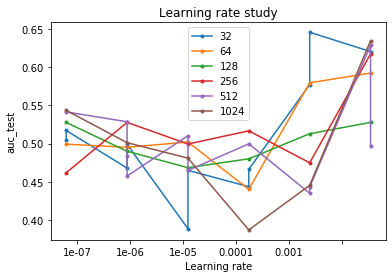

In [126]:
labels_x = df_results['learning'].unique()
df_results = df_results.sort_values('learning_log')
fig, ax = plt.subplots()

for key, grp in df_results.groupby(['batch']):
    ax = grp.plot(ax=ax, kind='line', x='learning_log', y='auc_test', label=key,style='.-',title = 'Learning rate study')
ax.set(xlabel="Learning rate", ylabel="auc_test")
ax.set_xticklabels(labels_x)
plt.legend(loc='best')
#plt.savefig("Plots/lr_collision_braking.png")

## Window size study - collision vs normal braking all data

Ths study is done over all subjects data with labels collision and normal braking 

In [46]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '9__windowsize_label_collision/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [47]:
values_auc_train = []
values_auc_test = []
iqr_auc_train = []
batch_size = []
learning_rate = []
window_size = []
convolution_size = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_train")
    path_meta = os.path.join(path_to_results,path_to_example, forlder_name, "meta_tags.csv")
    path_auc_test = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    
    if(os.path.isdir(path_auc_test)):
        meta_data = pd.read_csv(path_meta)
        batch_size.append(int(meta_data.loc[meta_data['key'] == 'batch_size', 'value']))
        learning_rate.append(float(meta_data.loc[meta_data['key'] == 'lr', 'value']))
        window_size.append(float(meta_data.loc[meta_data['key'] == 'window_size', 'value']))
        convolution_size.append(float(meta_data.loc[meta_data['key'] == 'convolution_size', 'value']))

        file_names = sorted(os.listdir(path=path_temp))
        file_names = [x for x in file_names if not x.startswith('.')]

        # file_names2 = sorted(os.listdir(path=path_temp2))
        # file_names2 = [x for x in file_names2 if not x.startswith('.')]
        value_temp =[]
        for event in summary_iterator(os.path.join(path_temp,file_names[0])):
            for value in event.summary.value:
                value_temp.append(value.simple_value)
        value_temp = np.array(value_temp)
        value_temp = value_temp[~np.isnan(value_temp)]
        values_auc_train.append(value_temp)
        iqr_auc_train.append(iqr(value_temp, rng=(0,100)))

        #
        #if(os.path.isdir(path_auc_test)):
        file_names = sorted(os.listdir(path=path_auc_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_auc_test,file_names[0])):
            for value in event.summary.value:
                values_auc_test.append(value.simple_value)
    #else:
    #    values_auc_test.append('nan')

In [48]:
df_results = pd.DataFrame({'batch':batch_size,'learning':learning_rate,
                           'learning_log':np.log(learning_rate), 
                           'iqr':iqr_auc_train, 
                           'auc_test':values_auc_test,
                           'window_size':window_size,
                           'convolution_size':convolution_size})

In [49]:
df_results

,batch,learning,learning_log,iqr,auc_test,window_size,convolution_size
0,512,0.00001,-11.512925,0.247787,0.472718,320.0,16.0
1,512,0.00001,-11.512925,0.281978,0.413711,280.0,16.0
2,512,0.00001,-11.512925,0.248633,0.447078,160.0,32.0
3,512,0.00001,-11.512925,0.250610,0.475462,200.0,32.0
4,512,0.00001,-11.512925,0.263994,0.447199,240.0,32.0
5,512,0.00001,-11.512925,0.262727,0.423191,280.0,32.0
6,512,0.00001,-11.512925,0.209646,0.419432,320.0,32.0
7,512,0.00001,-11.512925,0.230138,0.443451,240.0,16.0
8,512,0.00001,-11.512925,0.266219,0.444377,200.0,16.0
9,512,0.00001,-11.512925,0.242539,0.475749,160.0,16.0


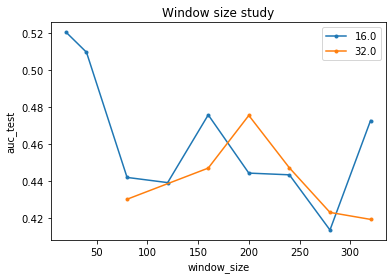

In [51]:
labels_x = df_results['learning'].unique()
df_results = df_results.sort_values('window_size')
fig, ax = plt.subplots()
for key, grp in df_results.groupby(['convolution_size']):
    ax = grp.plot(ax=ax, kind='line', x='window_size', y='auc_test', label=key,style='.-',title = 'Window size study')
ax.set(xlabel="window_size", ylabel="auc_test")
plt.legend(loc='best')
plt.savefig("Plots/windowsize_collision_braking.png")

## Window size study - collision vs normal braking BALANCED data

Ths study is done over balanced data for all subjects with labels collision and normal braking 

In [74]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '10__windowsize_label_collision_balanced/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [75]:
values_auc_train = []
values_auc_test = []
iqr_auc_train = []
batch_size = []
learning_rate = []
window_size = []
convolution_size = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_train")
    path_meta = os.path.join(path_to_results,path_to_example, forlder_name, "meta_tags.csv")
    path_auc_test = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    
    if(os.path.isdir(path_auc_test)):
        meta_data = pd.read_csv(path_meta)
        batch_size.append(int(meta_data.loc[meta_data['key'] == 'batch_size', 'value']))
        learning_rate.append(float(meta_data.loc[meta_data['key'] == 'lr', 'value']))
        window_size.append(float(meta_data.loc[meta_data['key'] == 'window_size', 'value']))
        convolution_size.append(float(meta_data.loc[meta_data['key'] == 'convolution_size', 'value']))

        file_names = sorted(os.listdir(path=path_temp))
        file_names = [x for x in file_names if not x.startswith('.')]

        # file_names2 = sorted(os.listdir(path=path_temp2))
        # file_names2 = [x for x in file_names2 if not x.startswith('.')]
        value_temp =[]
        for event in summary_iterator(os.path.join(path_temp,file_names[0])):
            for value in event.summary.value:
                value_temp.append(value.simple_value)
        value_temp = np.array(value_temp)
        value_temp = value_temp[~np.isnan(value_temp)]
        values_auc_train.append(value_temp)
        iqr_auc_train.append(iqr(value_temp, rng=(0,100)))

        #
        #if(os.path.isdir(path_auc_test)):
        file_names = sorted(os.listdir(path=path_auc_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_auc_test,file_names[0])):
            for value in event.summary.value:
                values_auc_test.append(value.simple_value)
    #else:
    #    values_auc_test.append('nan')

In [76]:
df_results_balanced = pd.DataFrame({'batch':batch_size,'learning':learning_rate,
                           'learning_log':np.log(learning_rate), 
                           'iqr':iqr_auc_train, 
                           'auc_test':values_auc_test,
                           'window_size':window_size,
                           'convolution_size':convolution_size})

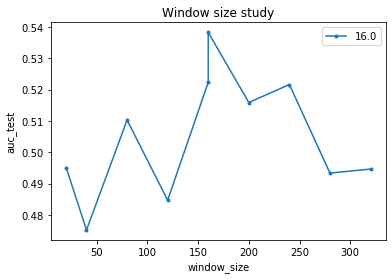

In [77]:
labels_x = df_results_balanced['learning'].unique()
df_results_balanced = df_results_balanced.sort_values('window_size')
fig, ax = plt.subplots()
for key, grp in df_results_balanced.groupby(['convolution_size']):
    ax = grp.plot(ax=ax, kind='line', x='window_size', y='auc_test', label=key,style='.-',title = 'Window size study')
ax.set(xlabel="window_size", ylabel="auc_test")
plt.legend(loc='best')
plt.savefig("Plots/windowsize_collision_braking_BALANCED.png")

## Window size study - collision vs normal braking all data filtered 1-8 HZ

Ths study is done over all subjects data with labels collision and normal braking 

In [108]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '11__windowsize_label_collision_filtered/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [109]:
values_auc_train = []
values_auc_test = []
iqr_auc_train = []
batch_size = []
learning_rate = []
window_size = []
convolution_size = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_train")
    path_meta = os.path.join(path_to_results,path_to_example, forlder_name, "meta_tags.csv")
    path_auc_test = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    
    if(os.path.isdir(path_auc_test)):
        meta_data = pd.read_csv(path_meta)
        batch_size.append(int(meta_data.loc[meta_data['key'] == 'batch_size', 'value']))
        learning_rate.append(float(meta_data.loc[meta_data['key'] == 'lr', 'value']))
        window_size.append(float(meta_data.loc[meta_data['key'] == 'window_size', 'value']))
        convolution_size.append(float(meta_data.loc[meta_data['key'] == 'convolution_size', 'value']))

        file_names = sorted(os.listdir(path=path_temp))
        file_names = [x for x in file_names if not x.startswith('.')]

        # file_names2 = sorted(os.listdir(path=path_temp2))
        # file_names2 = [x for x in file_names2 if not x.startswith('.')]
        value_temp =[]
        for event in summary_iterator(os.path.join(path_temp,file_names[0])):
            for value in event.summary.value:
                value_temp.append(value.simple_value)
        value_temp = np.array(value_temp)
        value_temp = value_temp[~np.isnan(value_temp)]
        values_auc_train.append(value_temp)
        iqr_auc_train.append(iqr(value_temp, rng=(0,100)))

        #
        #if(os.path.isdir(path_auc_test)):
        file_names = sorted(os.listdir(path=path_auc_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_auc_test,file_names[0])):
            for value in event.summary.value:
                values_auc_test.append(value.simple_value)
    #else:
    #    values_auc_test.append('nan')

In [110]:
df_results_filtered = pd.DataFrame({'batch':batch_size,'learning':learning_rate,
                           'learning_log':np.log(learning_rate), 
                           'iqr':iqr_auc_train, 
                           'auc_test':values_auc_test,
                           'window_size':window_size,
                           'convolution_size':convolution_size})

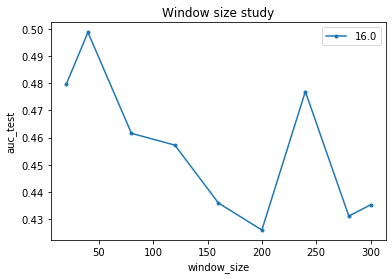

In [111]:
labels_x = df_results_filtered['learning'].unique()
df_results_filtered = df_results_filtered.sort_values('window_size')
fig, ax = plt.subplots()
for key, grp in df_results_filtered.groupby(['convolution_size']):
    ax = grp.plot(ax=ax, kind='line', x='window_size', y='auc_test', label=key,style='.-',title = 'Window size study')
ax.set(xlabel="window_size", ylabel="auc_test")
plt.legend(loc='best')
plt.savefig("Plots/windowsize_collision_braking_FILTERED.png")

## Window size study - collision vs normal braking BALANCED data filtered 1-8 HZ

Ths study is done over all subjects balanced data with labels collision and normal braking 

In [132]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '12__windowsize_label_collision_filtered_balanced/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [133]:
values_auc_train = []
values_auc_test = []
iqr_auc_train = []
batch_size = []
learning_rate = []
window_size = []
convolution_size = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_train")
    path_meta = os.path.join(path_to_results,path_to_example, forlder_name, "meta_tags.csv")
    path_auc_test = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    
    if(os.path.isdir(path_auc_test)):
        meta_data = pd.read_csv(path_meta)
        batch_size.append(int(meta_data.loc[meta_data['key'] == 'batch_size', 'value']))
        learning_rate.append(float(meta_data.loc[meta_data['key'] == 'lr', 'value']))
        window_size.append(float(meta_data.loc[meta_data['key'] == 'window_size', 'value']))
        convolution_size.append(float(meta_data.loc[meta_data['key'] == 'convolution_size', 'value']))

        file_names = sorted(os.listdir(path=path_temp))
        file_names = [x for x in file_names if not x.startswith('.')]

        # file_names2 = sorted(os.listdir(path=path_temp2))
        # file_names2 = [x for x in file_names2 if not x.startswith('.')]
        value_temp =[]
        for event in summary_iterator(os.path.join(path_temp,file_names[0])):
            for value in event.summary.value:
                value_temp.append(value.simple_value)
        value_temp = np.array(value_temp)
        value_temp = value_temp[~np.isnan(value_temp)]
        values_auc_train.append(value_temp)
        iqr_auc_train.append(iqr(value_temp, rng=(0,100)))

        #
        #if(os.path.isdir(path_auc_test)):
        file_names = sorted(os.listdir(path=path_auc_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_auc_test,file_names[0])):
            for value in event.summary.value:
                values_auc_test.append(value.simple_value)
    #else:
    #    values_auc_test.append('nan')

In [134]:
df_results_filtered_balanced = pd.DataFrame({'batch':batch_size,'learning':learning_rate,
                           'learning_log':np.log(learning_rate), 
                           'iqr':iqr_auc_train, 
                           'auc_test':values_auc_test,
                           'window_size':window_size,
                           'convolution_size':convolution_size})

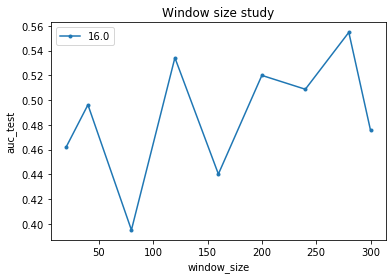

In [135]:
labels_x = df_results_filtered_balanced['learning'].unique()
df_results_filtered_balanced = df_results_filtered_balanced.sort_values('window_size')
fig, ax = plt.subplots()
for key, grp in df_results_filtered_balanced.groupby(['convolution_size']):
    ax = grp.plot(ax=ax, kind='line', x='window_size', y='auc_test', label=key,style='.-',title = 'Window size study')
ax.set(xlabel="window_size", ylabel="auc_test")
plt.legend(loc='best')
plt.savefig("Plots/windowsize_collision_braking_FILTERED_BALANCED.png")

## Window size study - collision vs normal braking BALANCED data filtered 1-8 HZ - SMALL NN

Ths study is done over all subjects balanced data with labels collision and normal braking 

In [149]:
path_to_results = '/Users/obando_c/Documents/Neuro/EmergencyBraking/results/'
path_to_example = '13__windowsize_label_collision_filtered_balanced_smallNN/lightning_logs/'
folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
folder_names = [x for x in folder_names if not x.startswith('.')]

In [151]:
values_auc_train = []
values_auc_test = []
values_f1score_test = []
iqr_auc_train = []
batch_size = []
learning_rate = []
window_size = []
convolution_size = []
for forlder_name in folder_names:
    #folder_names = sorted(os.listdir(path=path_to_results + path_to_example))
    path_temp = os.path.join(path_to_results,path_to_example, forlder_name, "auc_train")
    path_meta = os.path.join(path_to_results,path_to_example, forlder_name, "meta_tags.csv")
    path_auc_test = os.path.join(path_to_results,path_to_example, forlder_name, "auc_test")
    path_f1score_test = os.path.join(path_to_results,path_to_example, forlder_name, "f1score_test")
    
    if(os.path.isdir(path_auc_test)):
        meta_data = pd.read_csv(path_meta)
        batch_size.append(int(meta_data.loc[meta_data['key'] == 'batch_size', 'value']))
        learning_rate.append(float(meta_data.loc[meta_data['key'] == 'lr', 'value']))
        window_size.append(float(meta_data.loc[meta_data['key'] == 'window_size', 'value']))
        convolution_size.append(float(meta_data.loc[meta_data['key'] == 'convolution_size', 'value']))

        file_names = sorted(os.listdir(path=path_temp))
        file_names = [x for x in file_names if not x.startswith('.')]

        # file_names2 = sorted(os.listdir(path=path_temp2))
        # file_names2 = [x for x in file_names2 if not x.startswith('.')]
        value_temp =[]
        for event in summary_iterator(os.path.join(path_temp,file_names[0])):
            for value in event.summary.value:
                value_temp.append(value.simple_value)
        value_temp = np.array(value_temp)
        value_temp = value_temp[~np.isnan(value_temp)]
        values_auc_train.append(value_temp)
        iqr_auc_train.append(iqr(value_temp, rng=(0,100)))

        #
        #if(os.path.isdir(path_auc_test)):
        file_names = sorted(os.listdir(path=path_auc_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_auc_test,file_names[0])):
            for value in event.summary.value:
                values_auc_test.append(value.simple_value)
                
        file_names = sorted(os.listdir(path=path_f1score_test))
        file_names = [x for x in file_names if not x.startswith('.')]
        for event in summary_iterator(os.path.join(path_f1score_test,file_names[0])):
            for value in event.summary.value:
                values_f1score_test.append(value.simple_value)
    #else:
    #    values_auc_test.append('nan')

In [152]:
df_results_filtered_balanced = pd.DataFrame({'batch':batch_size,'learning':learning_rate,
                           'learning_log':np.log(learning_rate), 
                           'iqr':iqr_auc_train, 
                           'auc_test':values_auc_test,
                           'f1score_test':values_f1score_test,
                           'window_size':window_size,
                           'convolution_size':convolution_size})

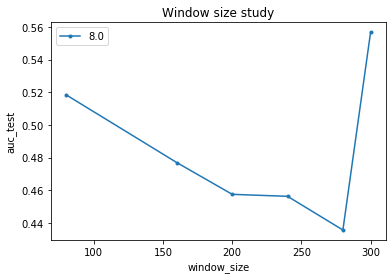

In [153]:
labels_x = df_results_filtered_balanced['learning'].unique()
df_results_filtered_balanced = df_results_filtered_balanced.sort_values('window_size')
fig, ax = plt.subplots()
for key, grp in df_results_filtered_balanced.groupby(['convolution_size']):
    ax = grp.plot(ax=ax, kind='line', x='window_size', y='auc_test', label=key,style='.-',title = 'Window size study')
ax.set(xlabel="window_size", ylabel="auc_test")
plt.legend(loc='best')
#plt.savefig("Plots/windowsize_collision_braking_FILTERED_BALANCED.png")

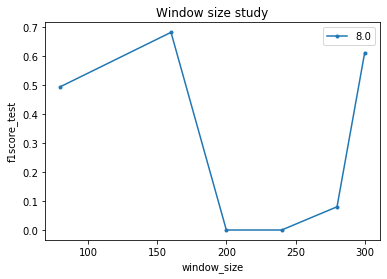

In [154]:
labels_x = df_results_filtered_balanced['learning'].unique()
df_results_filtered_balanced = df_results_filtered_balanced.sort_values('window_size')
fig, ax = plt.subplots()
for key, grp in df_results_filtered_balanced.groupby(['convolution_size']):
    ax = grp.plot(ax=ax, kind='line', x='window_size', y='f1score_test', label=key,style='.-',title = 'Window size study')
ax.set(xlabel="window_size", ylabel="f1score_test")
plt.legend(loc='best')
#plt.savefig("Plots/windowsize_collision_braking_FILTERED_BALANCED.png")

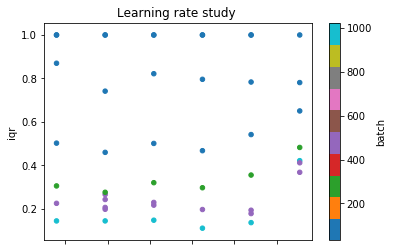

In [70]:
ax = df_results.plot(x='learning_log',
                      y='iqr',
                      c='batch',
                      colormap='tab10',
                      title = 'Learning rate study ',
                      kind = 'scatter')
#ax.set_xscale('log')
ax.set(xlabel="batch size", ylabel="iqr")
plt.savefig("Plots/lr_collision_braking.png")

[Text(0, 0.5, 'iqr'), Text(0.5, 0, 'batch size')]

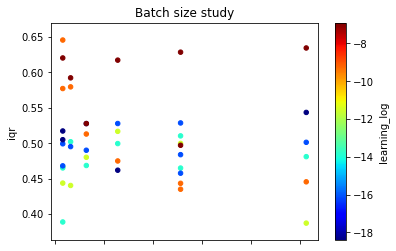

In [452]:
ax = df_results.plot(x='batch',
                      y='auc_test',
                      c='learning_log',
                      colormap='jet',
                      title = 'Batch size study',
                      kind = 'scatter')
ax.set(xlabel="batch size", ylabel="iqr")
#plt.savefig("Plots/batch_lr_collision_braking.png")

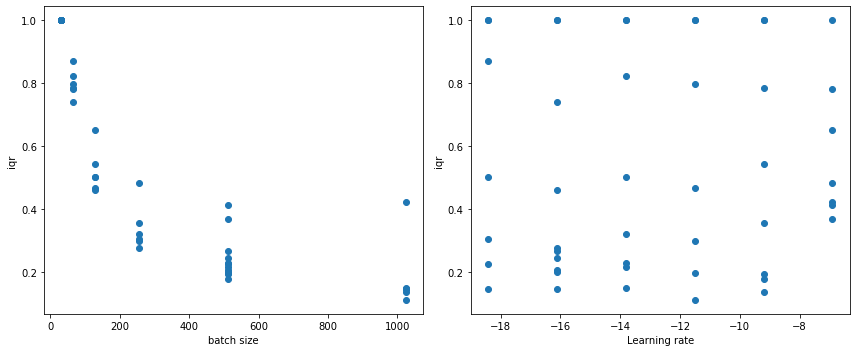

In [72]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.array(batch_size),np.array(iqr_auc_train),'o')
plt.xlabel('batch size')
plt.ylabel('iqr')
plt.subplot(1,2,2)
plt.plot(np.log(learning_rate),np.array(iqr_auc_train),'o')
plt.xlabel('Learning rate')
plt.ylabel('iqr')
plt.tight_layout()

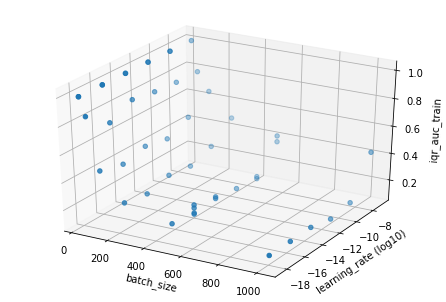

In [75]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.array(batch_size), np.log(learning_rate), np.array(iqr_auc_train))
#ax.xaxis.set_scale('log')
#ax.set_yscale('log')
ax.set_xlabel('batch_size')
ax.set_ylabel('learning_rate (log10)')
ax.set_zlabel('iqr_auc_train')
plt.show()

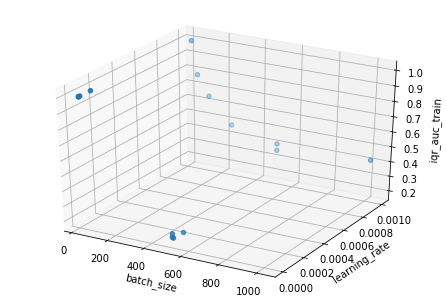

In [294]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.array(batch_size), np.array(learning_rate), np.array(iqr_auc_train))

ax.set_xlabel('batch_size')
ax.set_ylabel('learning_rate')
ax.set_zlabel('iqr_auc_train')

plt.show()

In [163]:
path_temp,file_names[0]

('/Users/obando_c/Documents/Neuro/EmergencyBraking/results/4__label_collison/lightning_logs/version_0/auc_train',
 'events.out.tfevents.1604423527.TOLA320005482.69144.8')

In [114]:
x = np.array(values_auc_train)
x = x[~np.isnan(x)]

In [147]:
from scipy.stats import iqr
iqr(x, rng=(0,100))

1.0

In [138]:
print(len(np.where(x<0.6)[0]))
print(len(x))
print(np.std(x))
print(np.percentile(x, 50))

2460
23399
0.13426911129957406
0.7857142686843872


In [132]:
print(len(np.where(x<0.9)[0]))
print(np.mean(x))

19614
0.7702947508360164


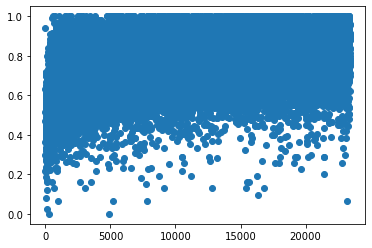

In [140]:
plt.plot(x,'o')

In [141]:
x

array([0.36296296, 0.4679487 , 0.21839081, ..., 0.78571427, 0.62179488,
       0.95512819])

## Checkpoint

In [3]:
# Local path to checkpoint folder
path_to_example_checkpoints = 'checkpoints/epoch=117.ckpt'
path_to_checkpoint = os.path.normpath(os.path.join(path_to_results,path_to_example, path_to_example_checkpoints))

checkpoint = torch.load(path_to_checkpoint)
for name,dict_ in checkpoint.items():
    print('the name of the dictionary is '+ name)

the name of the dictionary is epoch
the name of the dictionary is global_step
the name of the dictionary is checkpoint_callback_best
the name of the dictionary is optimizer_states
the name of the dictionary is lr_schedulers
the name of the dictionary is state_dict
the name of the dictionary is hparams
the name of the dictionary is hparams_type


### Look inside data

**epoch**  &emsp; &emsp; &emsp;  &emsp;&emsp;&emsp;&emsp; &emsp;&emsp; &emsp; &nbsp;  *epoch*  <br>
**global_step**  &emsp; &emsp; &emsp;&emsp;  &emsp; &emsp; &emsp; &nbsp;*global step*  <br>
**checkpoint_callback_best** &emsp; *check point callback best* <br>
**optimizer_states** &emsp; &emsp; &emsp; &emsp; &emsp;  *Optimizer states* <br>
**lr_schedulers** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;  *lr_schedulers* <br>
**state_dict** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;&emsp;&emsp;  *Parameters of each layer of the NN* <br>
**hparams** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;&emsp;&emsp;  *hyperparameters* <br>
**hparams_type** &emsp; &emsp; &emsp; &emsp;&emsp;&emsp;  *namespace* <br>

In [26]:
epoch = checkpoint['epoch']
epoch

118

In [27]:
global_step = checkpoint['global_step']
global_step

118

In [28]:
checkpoint_callback_best = checkpoint['checkpoint_callback_best']
checkpoint_callback_best

0.1415727287530899

In [18]:
optimizer_states = checkpoint['optimizer_states']
type(optimizer_states[0])
for name,dict_ in optimizer_states[0].items():
    print('the name of the dictionary is '+ name)

the name of the dictionary is state
the name of the dictionary is param_groups


In [19]:
optimizer_states_state = optimizer_states[0]['state']
for name,dict_ in optimizer_states_state.items():
    print('the name of the dictionary is '+ str(name))

the name of the dictionary is 112364145232
the name of the dictionary is 112364145952
the name of the dictionary is 112364146272
the name of the dictionary is 112364179856
the name of the dictionary is 112364180016
the name of the dictionary is 112364180816
the name of the dictionary is 112364180976


In [56]:
optimizer_states_param_groups = optimizer_states[0]['param_groups']
optimizer_states_param_groups

[{'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0.01,
  'amsgrad': False,
  'params': [112364145232,
   112364145952,
   112364146272,
   112364179856,
   112364180016,
   112364180816,
   112364180976]}]

In [36]:
lr_schedulers = checkpoint['lr_schedulers']
lr_schedulers

[]

In [38]:
state_dict = checkpoint['state_dict']
for name,dict_ in state_dict.items():
    print('the name of the dictionary is '+ name)

the name of the dictionary is net.spatial_filtering.transform.weight
the name of the dictionary is net.conv_block_1.transform.0.weight
the name of the dictionary is net.conv_block_1.transform.0.bias
the name of the dictionary is net.conv_block_2.transform.0.weight
the name of the dictionary is net.conv_block_2.transform.0.bias
the name of the dictionary is net.dense_block.transform.1.weight
the name of the dictionary is net.dense_block.transform.1.bias


In [39]:
hparams = checkpoint['hparams']
hparams

{'experiment': '4__label_collison',
 'fold': 0,
 'n_epochs': 1000,
 'batch_size': 1024,
 'lr': 0.001,
 'n_virtual_channels': 10,
 'convolution_size': 16,
 'pool_size': 8,
 'n_hidden_channels': 8,
 'n_time_series': 320,
 'n_channels': 59}

In [40]:
hparams_type = checkpoint['hparams_type']
hparams_type

'namespace'

## sen_test

In [13]:
path_to_example_sen_train = 'sen_train/events.out.tfevents.1599641646.TOLA320005482.8676.6'
path_to_sen_train = os.path.normpath(os.path.join(path_to_results,path_to_example, path_to_example_sen_train))